In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import joblib

sns.set(style="whitegrid")

df = pd.read_csv("creditcard.csv")
print("Columns in the dataset:", df.columns.tolist())

df['Amount'] = StandardScaler().fit_transform(df[['Amount']])
df = df.drop(['Time'], axis=1)

X = df.drop('Class', axis=1)
y = df['Class']

print("Original class distribution:")
print(y.value_counts())

#SMOTE was used to balance the highly imbalanced dataset by synthetically generating samples of the minority class (frauds)
#This ensures that the model doesn't become biased toward the majority class.
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nResampled class distribution:")
print(pd.Series(y_resampled).value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

train_df = pd.DataFrame(X_resampled, columns=X.columns)
train_df['Class'] = y_resampled.values
train_df.to_csv('training_dataset.csv', index=False)

test_df = X_test.copy()
test_df['True_Class'] = y_test.values
test_df['Predicted_Class'] = y_pred
test_df['Fraud_Probability'] = y_proba
test_df.to_csv('test_dataset.csv', index=False)

fraud_df = test_df[(test_df['True_Class'] == 1) | (test_df['Predicted_Class'] == 1)]
fraud_df.to_csv('fraud_cases_only.csv', index=False)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Columns in the dataset: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Original class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Resampled class distribution:
Class
0    284315
1    284315
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      1.00      1.00     85294

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



Confusion Matrix:


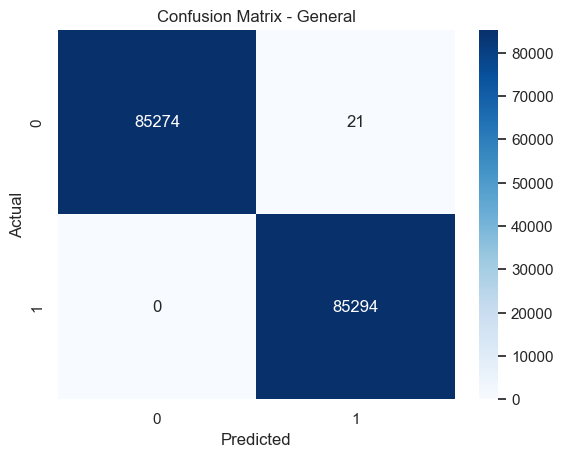

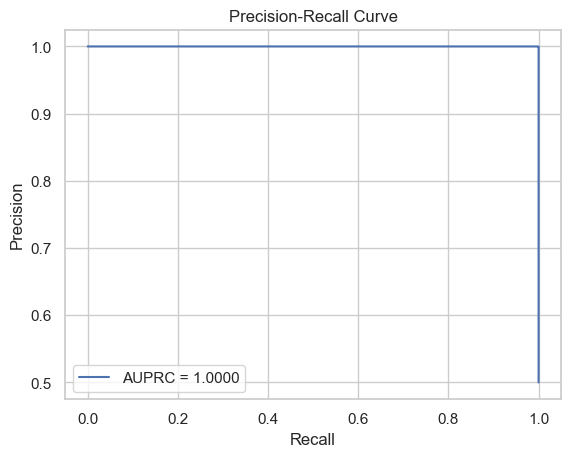

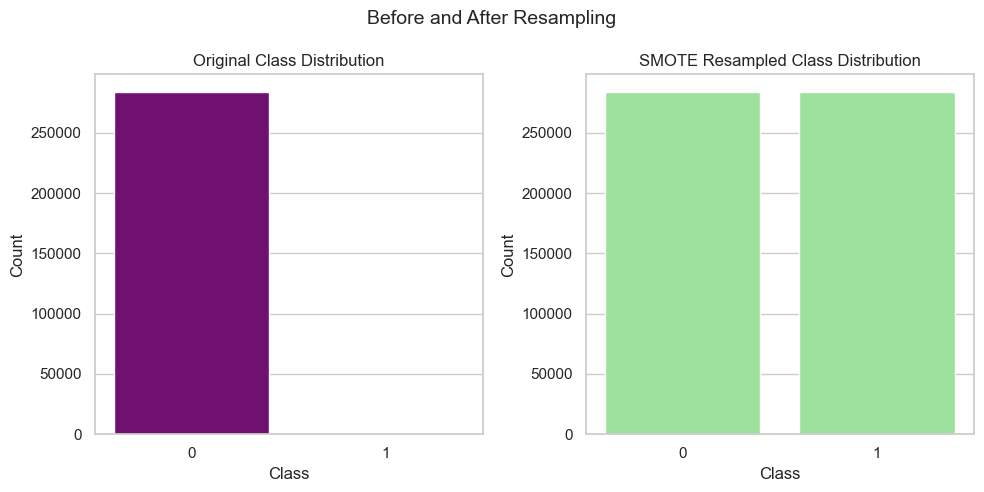

In [7]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - General")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

probs = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probs)
prc_auc = auc(recall, precision)

plt.plot(recall, precision, label=f'AUPRC = {prc_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

df['Predicted_Class'] = model.predict(X)
df['Fraud_Probability'] = model.predict_proba(X)[:, 1]
df[['Amount', 'Class', 'Predicted_Class', 'Fraud_Probability']].to_csv('all_predictions_with_probabilities.csv', index=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x=y, ax=ax[0], color='purple')
ax[0].set_title('Original Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

sns.countplot(x=y_resampled, ax=ax[1], color='lightgreen')
ax[1].set_title('SMOTE Resampled Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.suptitle('Before and After Resampling', fontsize=14)
plt.tight_layout()
plt.show()

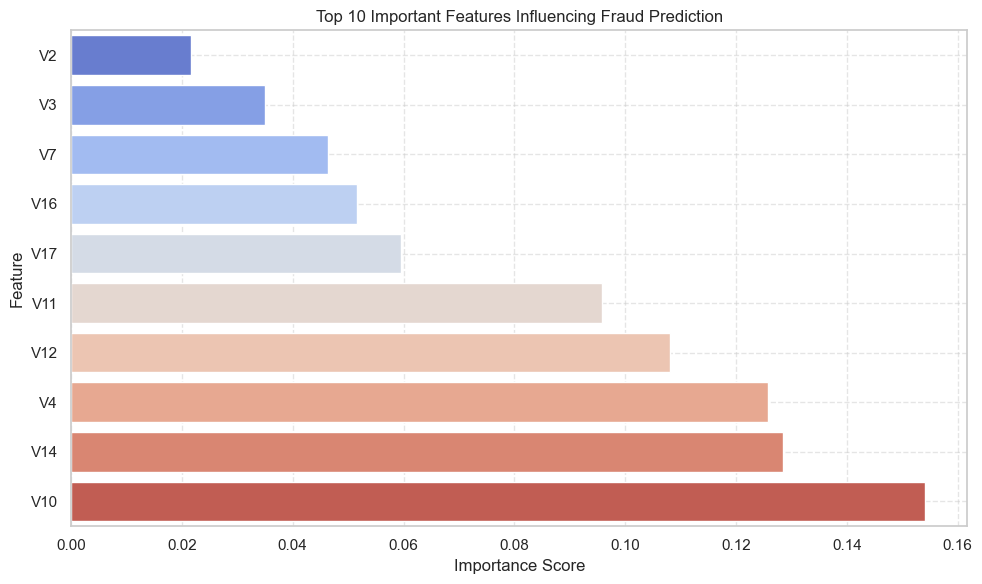

In [8]:
importances = model.feature_importances_
features = X.columns

top_idx = np.argsort(importances)[-10:]
top_features = features[top_idx]
top_importances = importances[top_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, hue=top_features,
            palette=sns.color_palette("coolwarm", n_colors=10), dodge=False, legend=False)
plt.title('Top 10 Important Features Influencing Fraud Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Features like V17, V14, V12 ranked highest in importance. 
##### These anonymized components (from PCA) carry patterns highly associated with fraud – perhaps capturing unusual transaction behaviors, spikes in activity, or rare combinations of values.
##### The model uses these features most often to split and decide if a transaction is fraudulent. 
##### Lower-ranked features like V28, V6, etc., contribute less to distinguishing fraud and are used less often in tree decision rules.

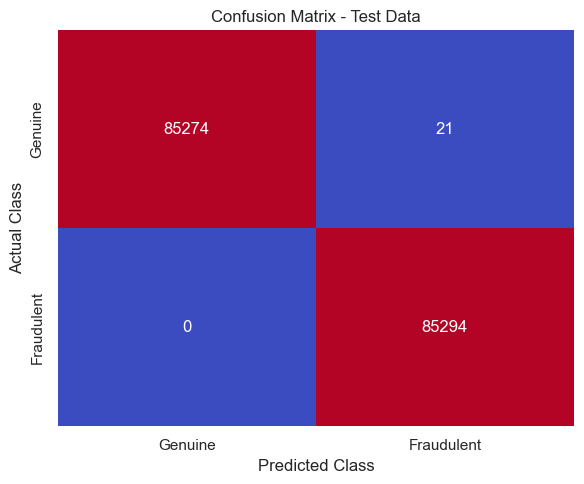

Top 10 Most Suspicious Transactions Based on Model:
     Amount  True_Class  Predicted_Class  Fraud_Probability
0 -0.352006           1                1                1.0
1 -0.349231           1                1                1.0
2  0.046539           1                1                1.0
3  0.379715           1                1                1.0
4 -0.218654           1                1                1.0
5 -0.181908           1                1                1.0
6 -0.138453           1                1                1.0
7 -0.337185           1                1                1.0
8 -0.349231           1                1                1.0
9 -0.122799           1                1                1.0


In [9]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm', cbar=False,
            xticklabels=['Genuine', 'Fraudulent'], yticklabels=['Genuine', 'Fraudulent'])
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()

top_suspicious = test_df.sort_values(by='Fraud_Probability', ascending=False).head(10)
top_suspicious_display = top_suspicious[['Amount', 'True_Class', 'Predicted_Class', 'Fraud_Probability']]
print("Top 10 Most Suspicious Transactions Based on Model:")
top_suspicious_display.reset_index(drop=True, inplace=True)
print(top_suspicious_display)

In [11]:
df['Predicted_Class'] = model.predict(X)
df['Fraud_Probability'] = model.predict_proba(X)[:, 1]
df.to_csv('final_model_predictions.csv', index=False)

In [10]:
joblib.dump(model, 'credit_fraud_model.pkl')
print("Model saved as 'credit_fraud_model.pkl'")

Model saved as 'credit_fraud_model.pkl'
